## **`New_Store`**

### Завдання: пошук найкращої локації для нового магазина

#### Дано:
* Метрика, що описує розподіл характеристики населення (`Population`)
* Метрика, що описує характеристику локації (`Stores`)

#### Необхідно:
1. Проаналізувати кореляцію характеристики магазину та населення (`SQL` / `Python`)
1. Візуалізувати результати дослідження, побудувати геокарту розподілу характеристик (будь-який доступний BI інструмент (`Power BI`, `Tableau`) / чи `Python`)
1. Запропонувати найкращі локації для відкриття нового store (за допомогою аналітичних досліджень або моделі)
1. Бонус: доповнити вибірку даними з будь-яких відкритих джерел

Уточнення:
1. Діапазону можливих значень (нижня/верхня межа змінної; контекст): не можна робити висновки, якщо не знати бізнес інтерпретації змінних. Ббентежать відємні значення.

Припущення:
1. Метрики це калібрований бал означає кращу популяцію чи продажі. Можливо це оцінки бізнес клімату чи загальні продажі в даному сегменті (ми+конкуренти).
1. Чи підходить Principal Component Analysis(PCA) для аналізу чи є кращий метод?

In [10]:
import pandas as pd
import openpyxl

ExcelFile_main_data = "ods/main_data.xlsx"

df_Population = pd.ExcelFile(ExcelFile_main_data).parse('Population')
df_Stores = pd.ExcelFile(ExcelFile_main_data).parse('Stores')

print("Population:")
print( df_Population.describe() )
print("Stores:")
print( df_Stores.describe() )

Population:
                lat           lon  metric population
count  12752.000000  12752.000000       12752.000000
mean      50.448166     30.508882           2.149327
std        0.038312      0.085991           0.440325
min       50.334463     30.318606          -0.229571
25%       50.424441     30.447162           1.910446
50%       50.444883     30.502212           2.149516
75%       50.471471     30.594576           2.426439
max       50.535869     30.717598           3.655685
Stores:
             lat       long  Metric Store
count  92.000000  92.000000     92.000000
mean   50.462205  30.524705      1.935000
std     0.043530   0.084080      0.616517
min    50.340938  30.337587      1.010000
25%    50.426479  30.458887      1.425000
50%    50.462090  30.516013      1.845000
75%    50.503453  30.602554      2.400000
max    50.533542  30.666180      3.000000


In [8]:
display(df_Population.sort_values(by='metric population'))
display(df_Stores.sort_values(by='Metric Store'))

,lat,lon,metric population
11689,50.500946,30.445755,-0.229571
10924,50.469955,30.423571,-0.065422
12065,50.469994,30.425226,-0.015759
10930,50.469930,30.422678,-0.006925
10964,50.469534,30.422925,-0.004603
...,...,...,...
10633,50.414012,30.540036,3.438066
11253,50.423042,30.538525,3.465973
3214,50.402219,30.630605,3.496600
12514,50.435559,30.616606,3.529561


,Store,lat,long,Metric Store
54,Store 55,50.509463,30.497693,1.01
53,Store 54,50.512704,30.496875,1.01
90,Store 91,50.411725,30.412683,1.01
19,Store 20,50.431315,30.383651,1.01
69,Store 70,50.486647,30.585121,1.02
...,...,...,...,...
58,Store 59,50.456693,30.383440,2.98
61,Store 62,50.459056,30.398850,2.98
14,Store 15,50.520226,30.514520,2.98
33,Store 34,50.401534,30.564091,3.00


In [13]:
import folium
from folium.plugins import HeatMap, HeatMapWithTime

#Population_gradient={0: 'white', 0.5: 'green', 1: 'blue'}
Population_gradient={0: 'white', 0.5: 'yellow', 1: 'purple'}
Stores_gradient={0: 'white', 0.5: 'yellow', 1: 'red'}

# Створення карти
m2 = folium.Map(df_Population[['lat', 'lon']].mean(), zoom_start=11)

# Додайте тепловий шар
HeatMap(data=df_Population[['lat', 'lon']], radius=12, gradient=Population_gradient).add_to(m2)
#HeatMap(data=df_Stores[['lat', 'long']], radius=12, gradient=Stores_gradient).add_to(m2)
HeatMap(data=df_Stores[['lat', 'long','Metric Store']], radius=0, blur=0, min_opacity=0, max_opacity=0, gradient=None, overlay=True, control=True, show=True, name=None).add_to(m2)
#for loc in data:
#    folium.Circle(location=loc[:2], radius=loc[2]/2, fill=True, color='red', fill_opacity=0.8).add_to(m2)

# Показати карту
m2

In [14]:
import numpy as np

df_Population['Population_ID'] = range(0, len(df_Population) )
df_Population['key'] = 0
df_Stores['key'] = 0

smpl = df_Population.merge(df_Stores, on='key', how='outer')
smpl['len'] = ( ((smpl['lat_x']-smpl['lat_y']) ** 2) + ((smpl['lon']-smpl['long']) ** 2) ).apply(np.sqrt)
smpl['rang'] = smpl.sort_values(['len'], ascending=True).groupby(['Population_ID']).cumcount()
smpl2 = smpl[smpl.rang==0]
display(smpl2)

,lat_x,lon,metric population,Population_ID,key,Store,lat_y,long,Metric Store,len,rang
83,50.435976,30.625646,1.957358,0,0,Store 84,50.427168,30.639200,2.68,0.016165,0
175,50.435185,30.626106,1.948965,1,0,Store 84,50.427168,30.639200,2.68,0.015353,0
267,50.436381,30.626037,1.698104,2,0,Store 84,50.427168,30.639200,2.68,0.016066,0
359,50.436153,30.626818,2.087091,3,0,Store 84,50.427168,30.639200,2.68,0.015298,0
451,50.435430,30.626640,2.133889,4,0,Store 84,50.427168,30.639200,2.68,0.015034,0
...,...,...,...,...,...,...,...,...,...,...,...
1172749,50.475089,30.447804,1.971530,12747,0,Store 26,50.470626,30.461664,1.85,0.014561,0
1172824,50.462290,30.487367,2.366262,12748,0,Store 9,50.462101,30.481258,2.66,0.006112,0
1172916,50.462651,30.487229,2.563051,12749,0,Store 9,50.462101,30.481258,2.66,0.005996,0
1173018,50.462345,30.488185,2.515801,12750,0,Store 19,50.462079,30.494244,2.01,0.006064,0


In [182]:
import matplotlib.pyplot as plt
l = smpl2.sort_values( ['Store', 'len'] ).reset_index(drop=True)
l = l[ ['Store', 'len'] ]
l2 = l.groupby(['Store']).min().sort_values( ['len'] )
#display( l2 )

smpl2['class'] = np.where(smpl2['len']<0.01, 'current', '' )
display( smpl2 )

C:\Users\klimc\AppData\Local\Temp/ipykernel_15368/3331976583.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smpl2['class'] = np.where(smpl2['len']<0.01, 'current', '' )


,lat_x,lon,metric population,Population_ID,key,Store,lat_y,long,Metric Store,len,rang,class
13,50.500946,30.445755,-0.229571,0,0,Store 14,50.500799,30.450873,1.61,0.005120,0,current
181,50.469955,30.423571,-0.065422,1,0,Store 90,50.472699,30.406233,1.84,0.017554,0,
273,50.469994,30.425226,-0.015759,2,0,Store 90,50.472699,30.406233,1.84,0.019185,0,
365,50.469930,30.422678,-0.006925,3,0,Store 90,50.472699,30.406233,1.84,0.016676,0,
457,50.469534,30.422925,-0.004603,4,0,Store 90,50.472699,30.406233,1.84,0.016990,0,
...,...,...,...,...,...,...,...,...,...,...,...,...
1172751,50.414012,30.540036,3.438066,12747,0,Store 28,50.410740,30.545757,1.04,0.006590,0,current
1172855,50.423042,30.538525,3.465973,12748,0,Store 40,50.427200,30.530629,1.54,0.008924,0,current
1172985,50.402219,30.630605,3.496600,12749,0,Store 78,50.400937,30.631575,2.65,0.001608,0,current
1173031,50.435559,30.616606,3.529561,12750,0,Store 32,50.417252,30.618417,1.99,0.018396,0,


,0,1,2,3,4,5,6,7,8,9,...,12742,12743,12744,12745,12746,12747,12748,12749,12750,12751
metric population,-0.229571,-0.065422,-0.015759,-0.006925,-0.004603,0.000878,0.070415,0.090159,0.105978,0.132011,...,3.413179,3.416138,3.42345,3.425845,3.430517,3.438066,3.465973,3.4966,3.529561,3.655685
Metric Store,1.610000,1.840000,1.840000,1.840000,1.840000,1.840000,1.840000,1.840000,1.840000,1.840000,...,1.410000,1.810000,2.97000,1.390000,1.790000,1.040000,1.540000,2.6500,1.990000,1.580000


0.0003568813489303741
0.01245970717444276
-0.017564884028338813


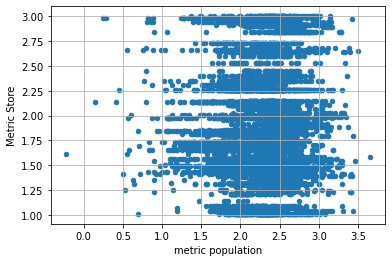

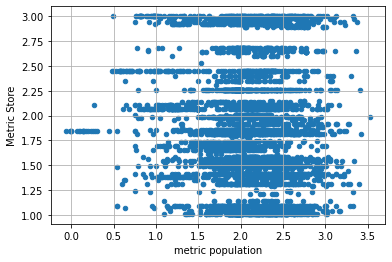

In [184]:
display( smpl2[['metric population', 'Metric Store']].reset_index(drop=True).transpose() )
smpl2[['metric population', 'Metric Store']][smpl2['class']=='current'].reset_index(drop=True).plot.scatter(0, 1, grid=True)
smpl2[['metric population', 'Metric Store']][smpl2['class']==''].reset_index(drop=True).plot.scatter(0, 1, grid=True)
print( smpl2['metric population'].cov(smpl2['Metric Store']) )
print( smpl2['metric population'][smpl2['class']=='current'].cov(smpl2['Metric Store']) )
print( smpl2['metric population'][smpl2['class']==''].cov(smpl2['Metric Store']) )